In [1]:
import pandas as pd
import torch
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torcheval import metrics
from ucimlrepo import fetch_ucirepo

In [2]:
class WineNN(nn.Module):
    def __init__(self, num_features, hidden_size, output_size):
        super(WineNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(num_features, hidden_size),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        self.out = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=-1),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out(x)
        return x

In [3]:
from sklearn.utils import shuffle

random_shuffle_state = 2024


def shuffle_train_valid_test_split(dataset: TensorDataset, valid_p=0.1, test_p=0.3):
    dataset = TensorDataset(
        *shuffle(*dataset.tensors, random_state=random_shuffle_state))

    train_offset = int(len(dataset) * (1 - (test_p + valid_p)))
    valid_offset = int(len(dataset) * valid_p) + train_offset

    return {
        "train": TensorDataset(*dataset[:train_offset]),
        "valid": TensorDataset(*dataset[train_offset:valid_offset]),
        "test":  TensorDataset(*dataset[valid_offset:])
    }

In [4]:
# import breast cancer & wine datasets
wine = fetch_ucirepo(id=109)

In [5]:
wine_scaler = StandardScaler()
wine_dataset = TensorDataset(
    torch.tensor(wine_scaler.fit_transform(
        wine.data.features), dtype=torch.float),
    torch.tensor(wine.data.targets.to_numpy() - 1).flatten()
)

wine_datasets = shuffle_train_valid_test_split(wine_dataset)
wine_headers: list = wine.data.headers[:-1].to_list()

In [6]:
datasets = wine_datasets

model = WineNN(wine.data.features.shape[1], 64, 3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)

In [7]:
losses = []
val_accuracy = []
val_losses = []

train_samples = len(datasets["train"])
val_samples = len(datasets["valid"])

train_loader = DataLoader(datasets["train"], batch_size=8, shuffle=True)

for epoch in range(20):
    running_loss = 0.0

    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    losses.append(running_loss / train_samples)

    model.eval()
    with torch.no_grad():
        inputs, targets = datasets["valid"][:]
        outputs = model(inputs)

        acc = metrics.functional.multiclass_accuracy(outputs, targets)
        loss = criterion(outputs, targets)

        val_accuracy.append(acc)
        val_losses.append(loss / val_samples)

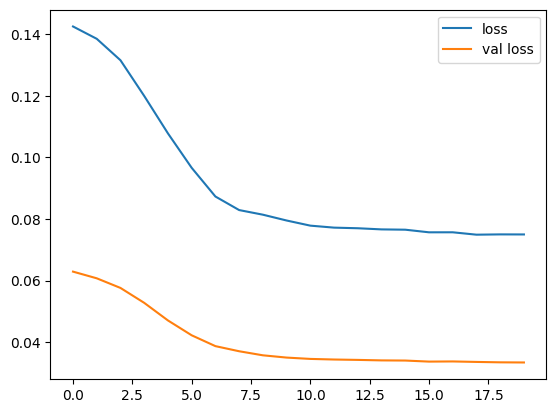

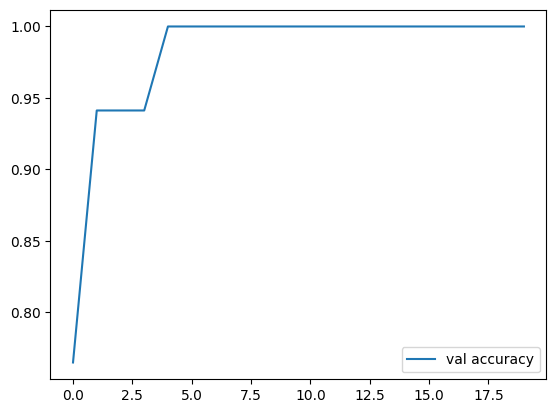

In [8]:
plt.plot(losses, label="loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.show()

plt.plot(val_accuracy, label="val accuracy")
plt.legend()
plt.show()

In [9]:
import SALib
import SALib.sample.finite_diff
import SALib.analyze.dgsm


def wrapped_model(inputs):
    inputs = torch.tensor(inputs, dtype=torch.float)
    with torch.no_grad():
        return model(inputs).detach().numpy()


problem = SALib.ProblemSpec({
    "num_vars": len(wine_headers),
    "names": wine_headers,
    "bounds": [[-1., 1.]] * len(wine_headers),
})

problem.items()

problem.sample(SALib.sample.finite_diff.sample, N=1024)
problem.evaluate(wrapped_model)
problem.analyze(SALib.analyze.dgsm.analyze)

problem

Samples:
	13 parameters: ['Alcohol', 'Malicacid', 'Ash', 'Alcalinity_of_ash', 'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins', 'Color_intensity', 'Hue', '0D280_0D315_of_diluted_wines', 'Proline']
	14336 samples
Outputs:
	3 outputs: ['Y1', 'Y2', 'Y3']
	14336 evaluations
Analysis:
Y1:
                                    vi    vi_std      dgsm  dgsm_conf
Alcohol                       0.063847  0.097078  0.261586   0.006102
Malicacid                     0.003386  0.008252  0.013874   0.000491
Ash                           0.019791  0.029691  0.081087   0.001963
Alcalinity_of_ash             0.020705  0.027100  0.084829   0.001370
Magnesium                     0.020576  0.032519  0.084300   0.002130
Total_phenols                 0.010878  0.014307  0.044568   0.000946
Flavanoids                    0.022532  0.044328  0.092316   0.002673
Nonflavanoid_phenols          0.019141  0.023809  0.078421   0.001423
Proanthocyanins               0.004038  0.008401

In [10]:
stats: pd.DataFrame = sum(problem.to_df())  # sum analysis over target classes
stats

,vi,vi_std,dgsm,dgsm_conf
Alcohol,0.174947,0.239845,0.735544,0.014220
Malicacid,0.029482,0.051726,0.183339,0.003226
Ash,0.051512,0.071530,0.214969,0.004535
Alcalinity_of_ash,0.038589,0.055805,0.159448,0.003273
Magnesium,0.059399,0.084149,0.251707,0.005297
Total_phenols,0.025102,0.033744,0.103047,0.002263
Flavanoids,0.080545,0.140559,0.506587,0.008724
Nonflavanoid_phenols,0.034726,0.053336,0.165494,0.003117
Proanthocyanins,0.015111,0.027928,0.089908,0.001788
Color_intensity,0.125348,0.174162,0.644145,0.010144


In [11]:
min_index = stats["dgsm"].argmin()
min_index, stats.iloc[min_index]

(8,
 vi           0.015111
 vi_std       0.027928
 dgsm         0.089908
 dgsm_conf    0.001788
 Name: Proanthocyanins, dtype: float64)

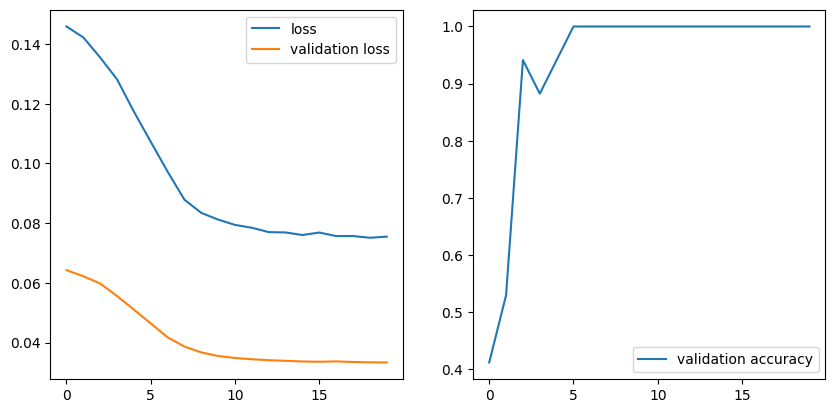

Test: loss: 0.6061035394668579, accuracy: 0.9636363387107849
dropping feature: (7, 'Nonflavanoid_phenols')


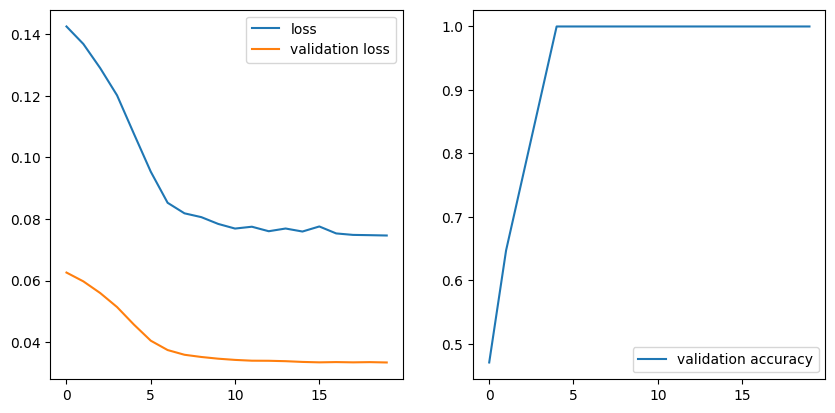

Test: loss: 0.5866875648498535, accuracy: 0.9636363387107849
dropping feature: (5, 'Total_phenols')


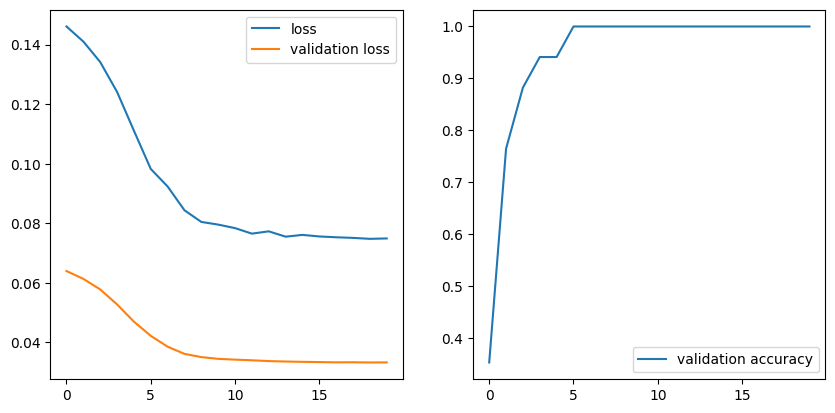

Test: loss: 0.5909594893455505, accuracy: 0.9636363387107849
dropping feature: (4, 'Magnesium')


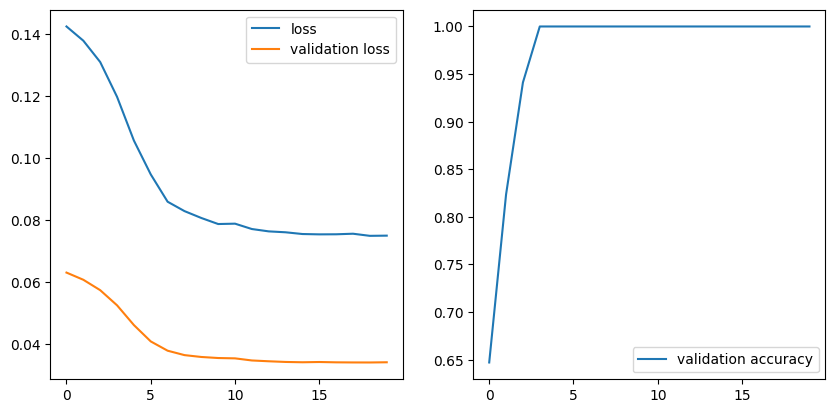

Test: loss: 0.562349259853363, accuracy: 1.0
dropping feature: (1, 'Malicacid')


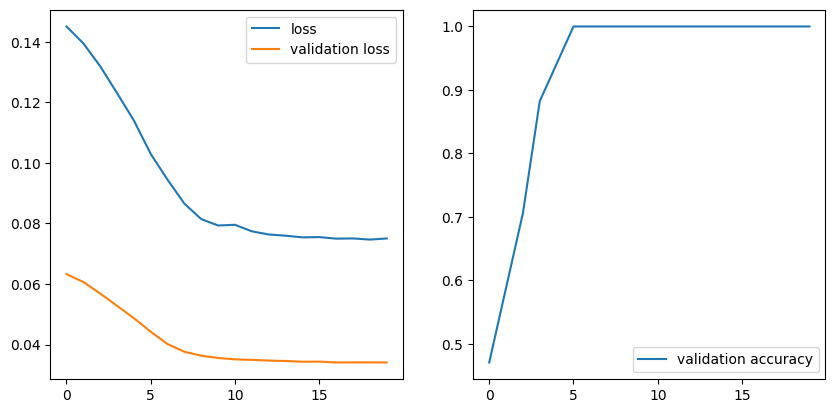

Test: loss: 0.5740453004837036, accuracy: 0.9818181991577148
dropping feature: (4, 'Proanthocyanins')


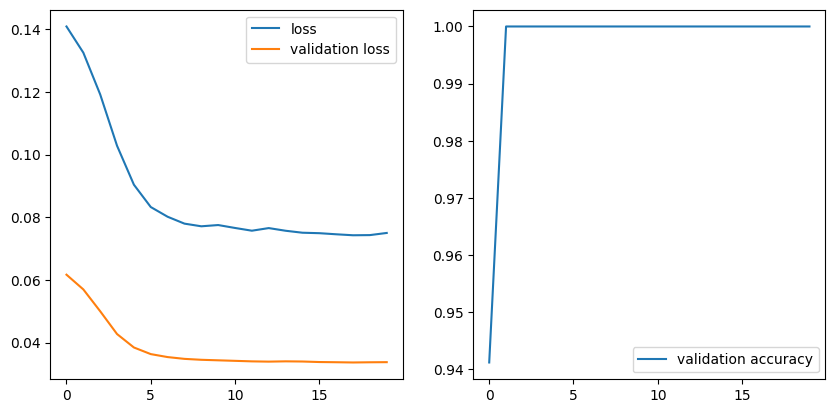

Test: loss: 0.5606080293655396, accuracy: 1.0
dropping feature: (2, 'Alcalinity_of_ash')


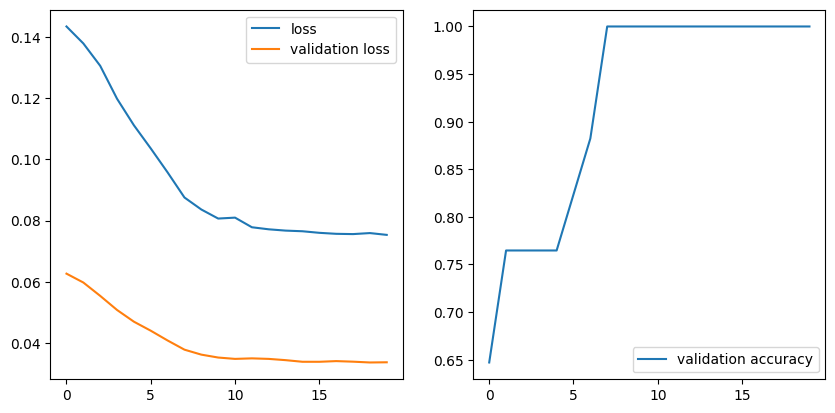

Test: loss: 0.5799608826637268, accuracy: 0.9818181991577148
dropping feature: (1, 'Ash')


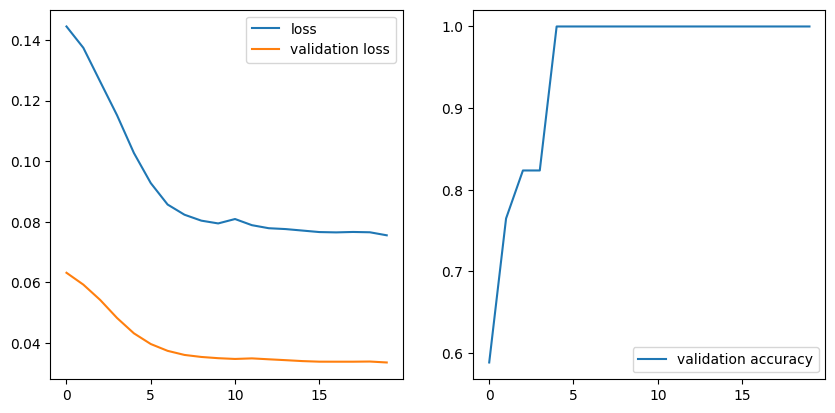

Test: loss: 0.5895636677742004, accuracy: 0.9818181991577148
dropping feature: (1, 'Flavanoids')


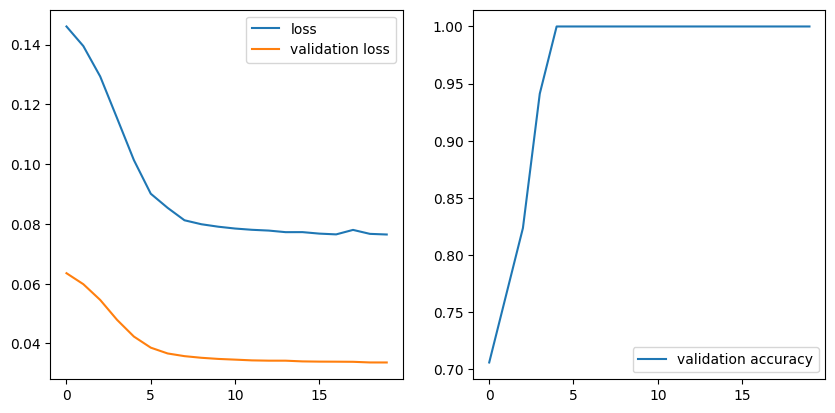

Test: loss: 0.5945515632629395, accuracy: 0.9636363387107849
dropping feature: (0, 'Alcohol')


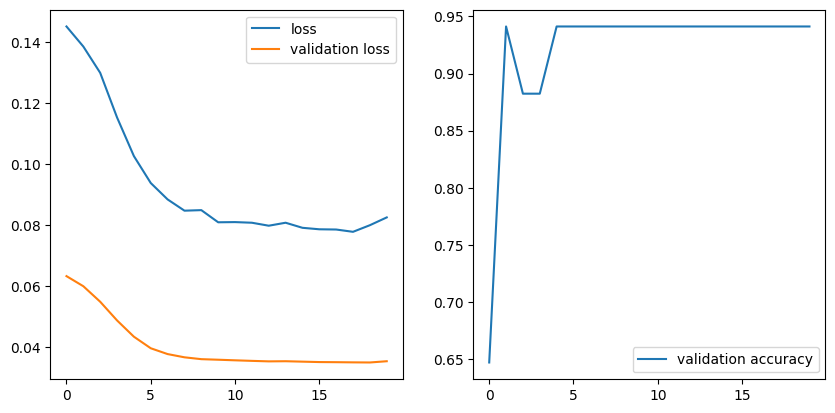

Test: loss: 0.6248449087142944, accuracy: 0.9272727370262146
dropping feature: (1, 'Hue')


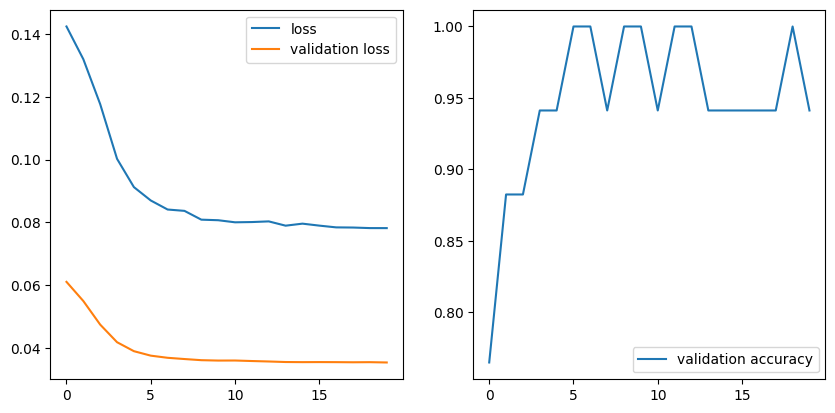

Test: loss: 0.6289347410202026, accuracy: 0.9272727370262146
dropping feature: (1, '0D280_0D315_of_diluted_wines')


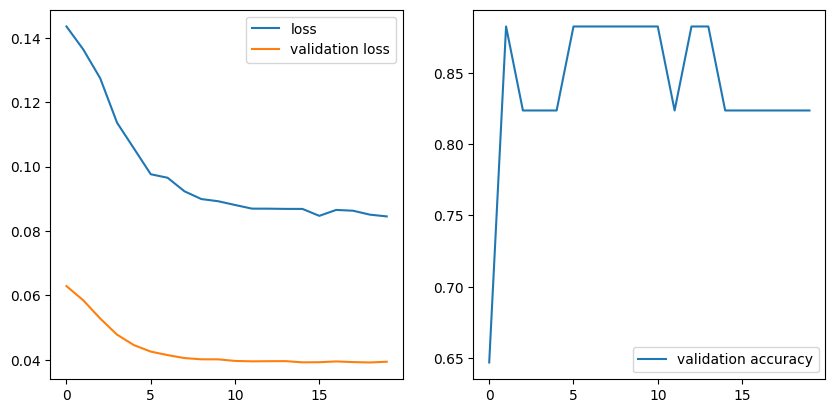

Test: loss: 0.6786213517189026, accuracy: 0.8545454740524292
dropping feature: (0, 'Color_intensity')


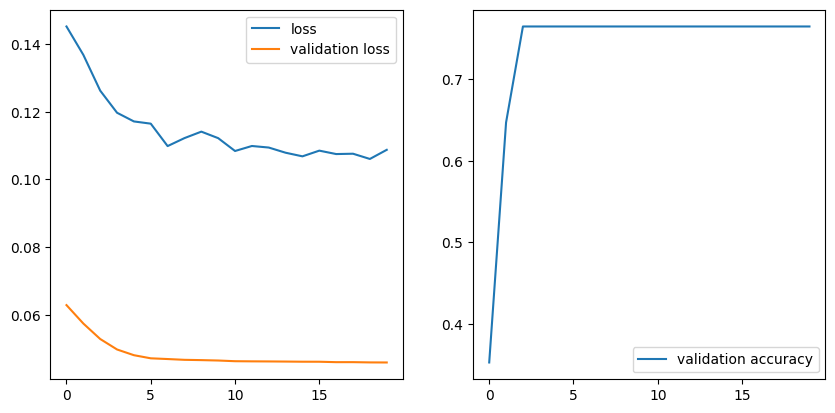

Test: loss: 0.8799250721931458, accuracy: 0.6545454263687134


In [12]:
# TODO: extraction to functions to accomodate other dataset+models?

datasets = wine_datasets.copy()
headers = wine_headers.copy()

criterion = nn.CrossEntropyLoss()
dropped_headers = []

# removing features loop
while len(headers) > 0:
    model = WineNN(len(headers), 64, 3)
    optimizer = optim.SGD(model.parameters(), lr=0.01,
                          momentum=0.9, weight_decay=5e-4)

    losses = []
    val_accuracy = []
    val_losses = []

    train_samples = len(datasets["train"])
    val_samples = len(datasets["valid"])

    train_loader = DataLoader(datasets["train"], batch_size=8, shuffle=True)

    for epoch in range(20):
        running_loss = 0.0

        model.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        losses.append(running_loss / train_samples)

        model.eval()
        with torch.no_grad():
            inputs, targets = datasets["valid"][:]
            outputs = model(inputs)

            acc = metrics.functional.multiclass_accuracy(outputs, targets)
            loss = criterion(outputs, targets)

            val_accuracy.append(acc)
            val_losses.append(loss / val_samples)

    with torch.no_grad():
        inputs, targets = datasets["test"][:]
        outputs = model(inputs)

        test_loss = criterion(outputs, targets)
        test_acc = metrics.functional.multiclass_accuracy(outputs, targets)

    # feel free to edit
    plt.gcf().set_figwidth(10)
    plt.subplot(1, 2, 1)
    plt.plot(losses, label="loss")
    plt.plot(val_losses, label="validation loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracy, label="validation accuracy")
    plt.legend()
    plt.show()

    print(f"Test: loss: {test_loss}, accuracy: {test_acc}")

    # sensitive analysis
    if len(headers) <= 1:
        break

    def wrapped_model(inputs):
        inputs = torch.tensor(inputs, dtype=torch.float)
        with torch.no_grad():
            return model(inputs).detach().numpy()

    problem = SALib.ProblemSpec({
        "num_vars": len(headers),
        "names": headers,
        "bounds": [[-1., 1.]] * len(headers),
    })

    problem.sample(SALib.sample.finite_diff.sample, N=1024)
    problem.evaluate(wrapped_model)
    problem.analyze(SALib.analyze.dgsm.analyze)

    min_index = sum(problem.to_df())['dgsm'].argmin()

    indexes = torch.arange(len(headers)) != min_index
    datasets = {
        key: TensorDataset(
            dataset.tensors[0][:, indexes],
            dataset.tensors[1]
        )
        for key, dataset in datasets.items()
    }

    dropped_headers.append((min_index, headers[min_index]))
    print(f"dropping feature: {dropped_headers[-1]}")
    del headers[min_index]

    print("="*50)